In [2]:
import os
import re
import requests
import pandas as pd
import string

# Ensure the folders exist
if not os.path.exists("eastcoast"):
    os.mkdir("eastcoast")

if not os.path.exists("westcoast"):
    os.mkdir("westcoast")

# Function to sanitize filenames
def sanitize_filename(filename):
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    sanitized_filename = ''.join(c for c in filename if c in valid_chars)
    return sanitized_filename

# Function to fetch Wikipedia content
def fetch_wikipedia_content(rapper_name):
    base_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": rapper_name
    }

    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        page_id = list(data['query']['pages'].keys())[0]
        content = data['query']['pages'][page_id]['revisions'][0]['*']
        
        # Extracting hyperlinks using regex
        hyperlinks = re.findall(r'\[\[(.+?)\]\]', content)
        hyperlinks_str = "\n".join(hyperlinks)
        return hyperlinks_str
    else:
        print(f"Failed to retrieve data for {rapper_name}")
        return None

# Function to save content to file
def save_content_to_file(folder_name, rapper_name, content):
    sanitized_name = sanitize_filename(rapper_name)
    with open(f"{folder_name}/{sanitized_name}.txt", "w", encoding="utf-8") as file:
        file.write(content)

# Fetch and store content for East Coast rappers
east_coast_rapper_df = pd.read_csv('EastCoastRappers.csv')
for _, rapper in east_coast_rapper_df.iterrows():
    content = fetch_wikipedia_content(rapper['WikipediaPageName'])
    if content:
        save_content_to_file("eastcoast", rapper['WikipediaPageName'], content)

# Fetch and store content for West Coast rappers
west_coast_rapper_df = pd.read_csv('WestCoastRappers.csv')
for _, rapper in west_coast_rapper_df.iterrows():
    content = fetch_wikipedia_content(rapper['WikipediaPageName'])
    if content:
        save_content_to_file("westcoast", rapper['WikipediaPageName'], content)




In [3]:
import os
import networkx as nx
import matplotlib.pyplot as plt

# Load content from saved files
def load_content_from_files(folder_name):
    rapper_connections = {}
    for filename in os.listdir(folder_name):
        rapper_name = filename[:-4]  # Remove .txt extension
        with open(f"{folder_name}/{filename}", "r", encoding="utf-8") as file:
            content = file.readlines()
        rapper_connections[rapper_name] = [line.strip() for line in content]
    return rapper_connections

east_coast_connections = load_content_from_files("eastcoast")
west_coast_connections = load_content_from_files("westcoast")

# Create a network graph
G = nx.DiGraph()

# Populate graph from loaded contents
def populate_graph_from_connections(connections, color):
    for rapper_name, linked_rappers in connections.items():
        G.add_node(rapper_name, color=color)
        for linked_rapper in linked_rappers:
            G.add_edge(rapper_name, linked_rapper)

populate_graph_from_connections(east_coast_connections, 'skyblue')
populate_graph_from_connections(west_coast_connections, 'salmon')

# Remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Extract the largest weakly connected component
components = list(nx.weakly_connected_components(G))
largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)





# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2023/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 26th, 2023 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/

The assignment should be handed in as a group. To do this, all group members must register for peergrade individually. See how to hand in as a group here: https://help.peergrade.io/en/articles/69783-how-to-submit-as-a-group .

(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

# Part 0: Building the network

**Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.**

We did not use Zelda API, our strategy was a mix of wiki API, Regular Expressions,File I/O,Pandas DataFrames:
Content Sanitization and requests library from python.

- **wiki API**
    The code fetches content from Wikipedia using their API, specifically the w/api.php endpoint. This is done by the function fetch_wikipedia_content(rapper_name). The code retrieves the latest revision content for the given Wikipedia page name (assumed to be a rapper's name).
    
    

- **Regular Expressions:**
After obtaining the Wikipedia content for the specified rapper, the code then uses a regular expression to extract hyperlinks embedded within the content. The specific regex used is r'\[\[(.+?)\]\]', which captures content between double square brackets '[[ ]]'. This is a common markup used in Wikipedia to denote internal links.

- **File I/O:**
The code first ensures that the directories eastcoast and westcoast exist. If not, it creates them. These directories are presumably where the code will save the hyperlinks extracted for each rapper.
The save_content_to_file() function is then used to save the hyperlinks to text files, one for each rapper. Filenames are sanitized to ensure they're valid and safe for file creation using the sanitize_filename() function.



- **Pandas DataFrames**
The code utilizes the pandas library to read CSV files that contain rapper names (or Wikipedia page names which is the column for rapper's names). It then iterates through these DataFrames row by row to fetch the content from Wikipedia according to the name of the rapper in the dataframe and save the extracted hyperlinks to text files.

- **Content Sanitization**
The function sanitize_filename(filename) ensures that the filename used to save the text files is clean and devoid of any characters that might cause file creation to fail. we had to write this function because some of the names were not the normal names.

**Show the regular expression(s) you have built and explain in details how it works.**

# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

- **What is the number of nodes in the network**

In [6]:
#Extract the weakly connected components from the graph
weakly_components = list(nx.weakly_connected_components(G))

#Identify the largest weakly connected component
largest_weakly_component = max(weakly_components, key=len)

# Count the number of nodes in this component
num_nodes_in_largest_component = len(largest_weakly_component)

print(f"Number of Nodes in the Largest Weakly Connected Component: {num_nodes_in_largest_component}")


Number of Nodes in the Largest Weakly Connected Component: 34207


- **What is the number of links?**

In [7]:
# Extract the weakly connected components from the graph
weakly_components = list(nx.weakly_connected_components(G))

#Identify the largest weakly connected component
largest_weakly_component = max(weakly_components, key=len)

# 3. Create a subgraph based on this component
subgraph = G.subgraph(largest_weakly_component)

# 4. Count the number of edges in this subgraph
num_edges_in_largest_component = subgraph.number_of_edges()

print(f"Number of Links in the Largest Weakly Connected Component: {num_edges_in_largest_component}")


Number of Links in the Largest Weakly Connected Component: 77639


- **Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?**

In [8]:
# Extract all rappers' Wikipedia page names
all_rappers = east_coast_rapper_df['WikipediaPageName'].tolist() + west_coast_rapper_df['WikipediaPageName'].tolist()

# Filtering the subgraph nodes to ensure only rappers are considered
subgraph_rapper_nodes = [node for node in subgraph.nodes() if node in all_rappers]

# Calculate in-degrees and out-degrees for the subgraph
in_degrees_subgraph = subgraph.in_degree(subgraph_rapper_nodes)
out_degrees_subgraph = subgraph.out_degree(subgraph_rapper_nodes)

# Finding the top rapper by in-degree and out-degree
top_rapper_by_in_degree = max(in_degrees_subgraph, key=lambda item: item[1])
top_rapper_by_out_degree = max(out_degrees_subgraph, key=lambda item: item[1])

print(f"Top Rapper by In-Degree (filtered): {top_rapper_by_in_degree[0]} with {top_rapper_by_in_degree[1]} in-links.")
print(f"Top Rapper by Out-Degree (filtered): {top_rapper_by_out_degree[0]} with {top_rapper_by_out_degree[1]} out-links.")


Top Rapper by In-Degree (filtered): Snoop Dogg with 123 in-links.
Top Rapper by Out-Degree (filtered): John Cena with 896 out-links.


The results is showing the rappers that are most referenced by other Wikipedia pages (based on in-degree) and those that reference the most other rappers or entities (based on out-degree).
If the top connected rapper by in-degree is someone well-known or influential in the rap industry, then this is an expected result as they would be more commonly referenced or discussed.
However, it's possible that the results can be influenced by factors such as recent events, controversies, collaborations, or other factors that may cause a particular rapper's Wikipedia page to be more linked to or from
WE understand why  Drag-On is topping the out degree, it is beause he is more famous in other areas as well like movies and wrestling performences

- **Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)?**

In [9]:
# Filter the subgraph nodes to include only East Coast rappers
east_coast_rappers_list = east_coast_rapper_df['WikipediaPageName'].tolist()
subgraph_east_coast_nodes = [node for node in subgraph.nodes() if node in east_coast_rappers_list]

# Calculate in-degrees and out-degrees for East Coast rappers in the subgraph
in_degrees_east_coast_subgraph = subgraph.in_degree(subgraph_east_coast_nodes)
out_degrees_east_coast_subgraph = subgraph.out_degree(subgraph_east_coast_nodes)

# Finding the top 5 East Coast rappers by in-degree
sorted_in_degrees = sorted(in_degrees_east_coast_subgraph, key=lambda item: item[1], reverse=True)[:5]

# Finding the top 5 East Coast rappers by out-degree
sorted_out_degrees = sorted(out_degrees_east_coast_subgraph, key=lambda item: item[1], reverse=True)[:5]

print("Top 5 East Coast Rappers by In-Degree:")
for rapper, degree in sorted_in_degrees:
    print(f"{rapper} with {degree} in-links.")

print("\nTop 5 East Coast Rappers by Out-Degree:")
for rapper, degree in sorted_out_degrees:
    print(f"{rapper} with {degree} out-links.")


Top 5 East Coast Rappers by In-Degree:
Jay-Z with 113 in-links.
Nas with 98 in-links.
50 Cent with 91 in-links.
Busta Rhymes with 83 in-links.
Wiz Khalifa with 57 in-links.

Top 5 East Coast Rappers by Out-Degree:
John Cena with 896 out-links.
Jay-Z with 603 out-links.
Cardi B with 576 out-links.
50 Cent with 503 out-links.
Queen Latifah with 496 out-links.


- **Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?**

In [10]:
# Filter the subgraph nodes to only include West Coast rappers
west_coast_rappers_list = west_coast_rapper_df['WikipediaPageName'].tolist()
subgraph_west_coast_nodes = [node for node in subgraph.nodes() if node in west_coast_rappers_list]

# Calculate in-degrees and out-degrees for West Coast rappers in the subgraph
in_degrees_west_coast_subgraph = subgraph.in_degree(subgraph_west_coast_nodes)
out_degrees_west_coast_subgraph = subgraph.out_degree(subgraph_west_coast_nodes)

# Finding the top 5 West Coast rappers by in-degree
sorted_in_degrees_west = sorted(in_degrees_west_coast_subgraph, key=lambda item: item[1], reverse=True)[:5]

# Finding the top 5 West Coast rappers by out-degree
sorted_out_degrees_west = sorted(out_degrees_west_coast_subgraph, key=lambda item: item[1], reverse=True)[:5]

print("Top 5 West Coast Rappers by In-Degree:")
for rapper, degree in sorted_in_degrees_west:
    print(f"{rapper} with {degree} in-links.")

print("\nTop 5 West Coast Rappers by Out-Degree:")
for rapper, degree in sorted_out_degrees_west:
    print(f"{rapper} with {degree} out-links.")


Top 5 West Coast Rappers by In-Degree:
Snoop Dogg with 123 in-links.
Dr. Dre with 81 in-links.
Kendrick Lamar with 75 in-links.
E-40 with 63 in-links.
Tupac Shakur with 54 in-links.

Top 5 West Coast Rappers by Out-Degree:
Snoop Dogg with 651 out-links.
Kendrick Lamar with 649 out-links.
Dr. Dre with 608 out-links.
Ice-T with 557 out-links.
Tupac Shakur with 508 out-links.


**Plot the in- and out-degree distributions for the whole network.**
- Use axes that make sense for visualizing this particular distribution.
- What do you observe?
- Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
- Find the exponent (by using the powerlaw package) for the in- and out-degree distributions. What does it say about our network?
- Compare the two degree distributions two the degree distribution of a random network (undirected) with the same number of nodes and probability of connection p. Comment your results

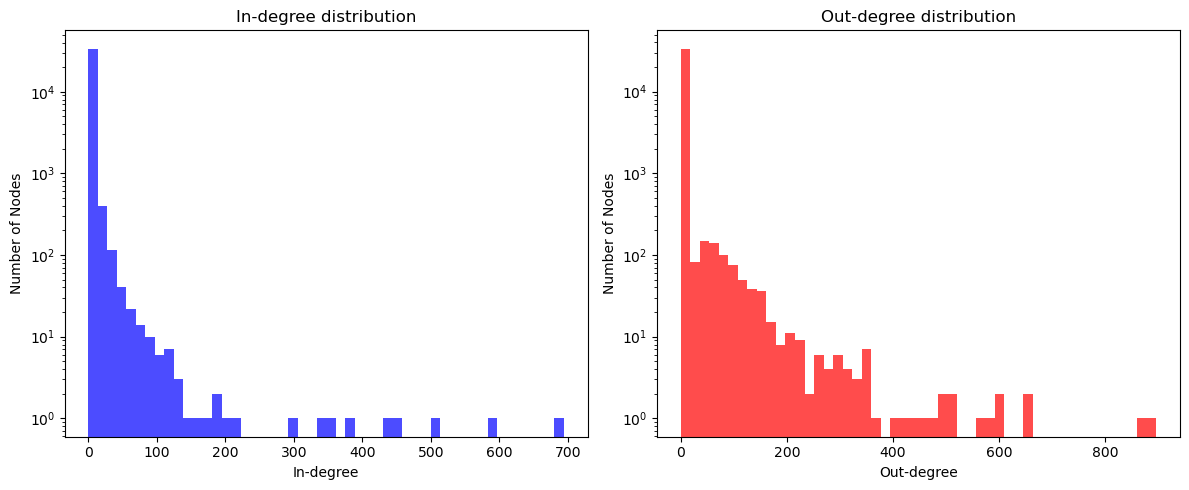

In [11]:
# Extract in-degree and out-degree from the subgraph
in_degrees = dict(subgraph.in_degree())
out_degrees = dict(subgraph.out_degree())

# Extract the degree values for plotting
degrees_in = list(in_degrees.values())
degrees_out = list(out_degrees.values())

# Plot the distributions
plt.figure(figsize=(12, 5))

# In-degree distribution
plt.subplot(1, 2, 1)
plt.hist(degrees_in, bins=50, log=True, color='blue', alpha=0.7)
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Number of Nodes")

# Out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(degrees_out, bins=50, log=True, color='red', alpha=0.7)
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Number of Nodes")

# Layout and display
plt.tight_layout()
plt.show()


**What do we observe and pedagogical explaination of why the in-degree distribution is different from the out-degree distribution**
we observe more dense out degree and less dense in degree and one of the reason is that each rapper's Wikipedia page will contain a certain number of links to other rappers.
A dense out-degree distribution suggests that many rappers' Wikipedia pages link out to a relatively consistent and large number of other rappers.
This might be because Wikipedia pages, especially for topics in a similar domain (like rappers), tend to link out to many related pages to provide context, background, or further reading. Editors might add many links to related rappers, music genres, albums, etc.

**Find the exponent (by using the powerlaw package) for the in- and out-degree distributions. What does it say about our network?**

In [12]:
import powerlaw
in_degrees = list(dict(subgraph.in_degree()).values())
out_degrees = list(dict(subgraph.out_degree()).values())

# Fit the in-degree distribution data to a power law model
fit_in = powerlaw.Fit(in_degrees, discrete=True)
exponent_in = fit_in.alpha

# Fit the out-degree distribution data to a power law model
fit_out = powerlaw.Fit(out_degrees, discrete=True)
exponent_out = fit_out.alpha

print(f"Exponent of the in-degree distribution: {exponent_in:.2f}")
print(f"Exponent of the out-degree distribution: {exponent_out:.2f}")


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Exponent of the in-degree distribution: 2.22
Exponent of the out-degree distribution: 2.97


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


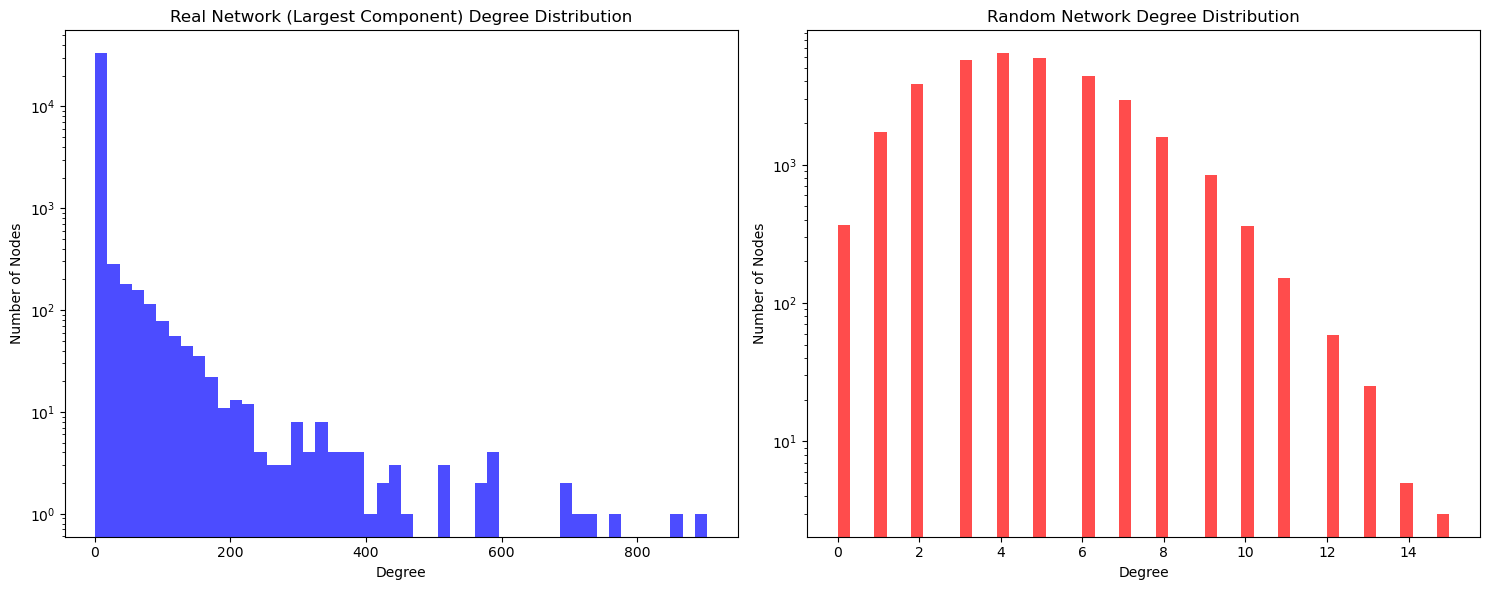

In [13]:
import numpy as np

# Get the degrees of the largest weakly connected component
degrees_real = [deg for node, deg in subgraph.degree()]

# 1. Generate a random network
num_nodes = len(subgraph.nodes())
num_edges = len(subgraph.edges())
p = num_edges / (num_nodes * (num_nodes - 1) / 2)  # for undirected graphs

random_graph = nx.erdos_renyi_graph(num_nodes, p)

# 2. Visualize degree distributions
degrees_random = [deg for node, deg in random_graph.degree()]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(degrees_real, bins=50, log=True, color='blue', alpha=0.7)
plt.title("Real Network (Largest Component) Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")

plt.subplot(1, 2, 2)
plt.hist(degrees_random, bins=50, log=True, color='red', alpha=0.7)
plt.title("Random Network Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")

plt.tight_layout()
plt.show()


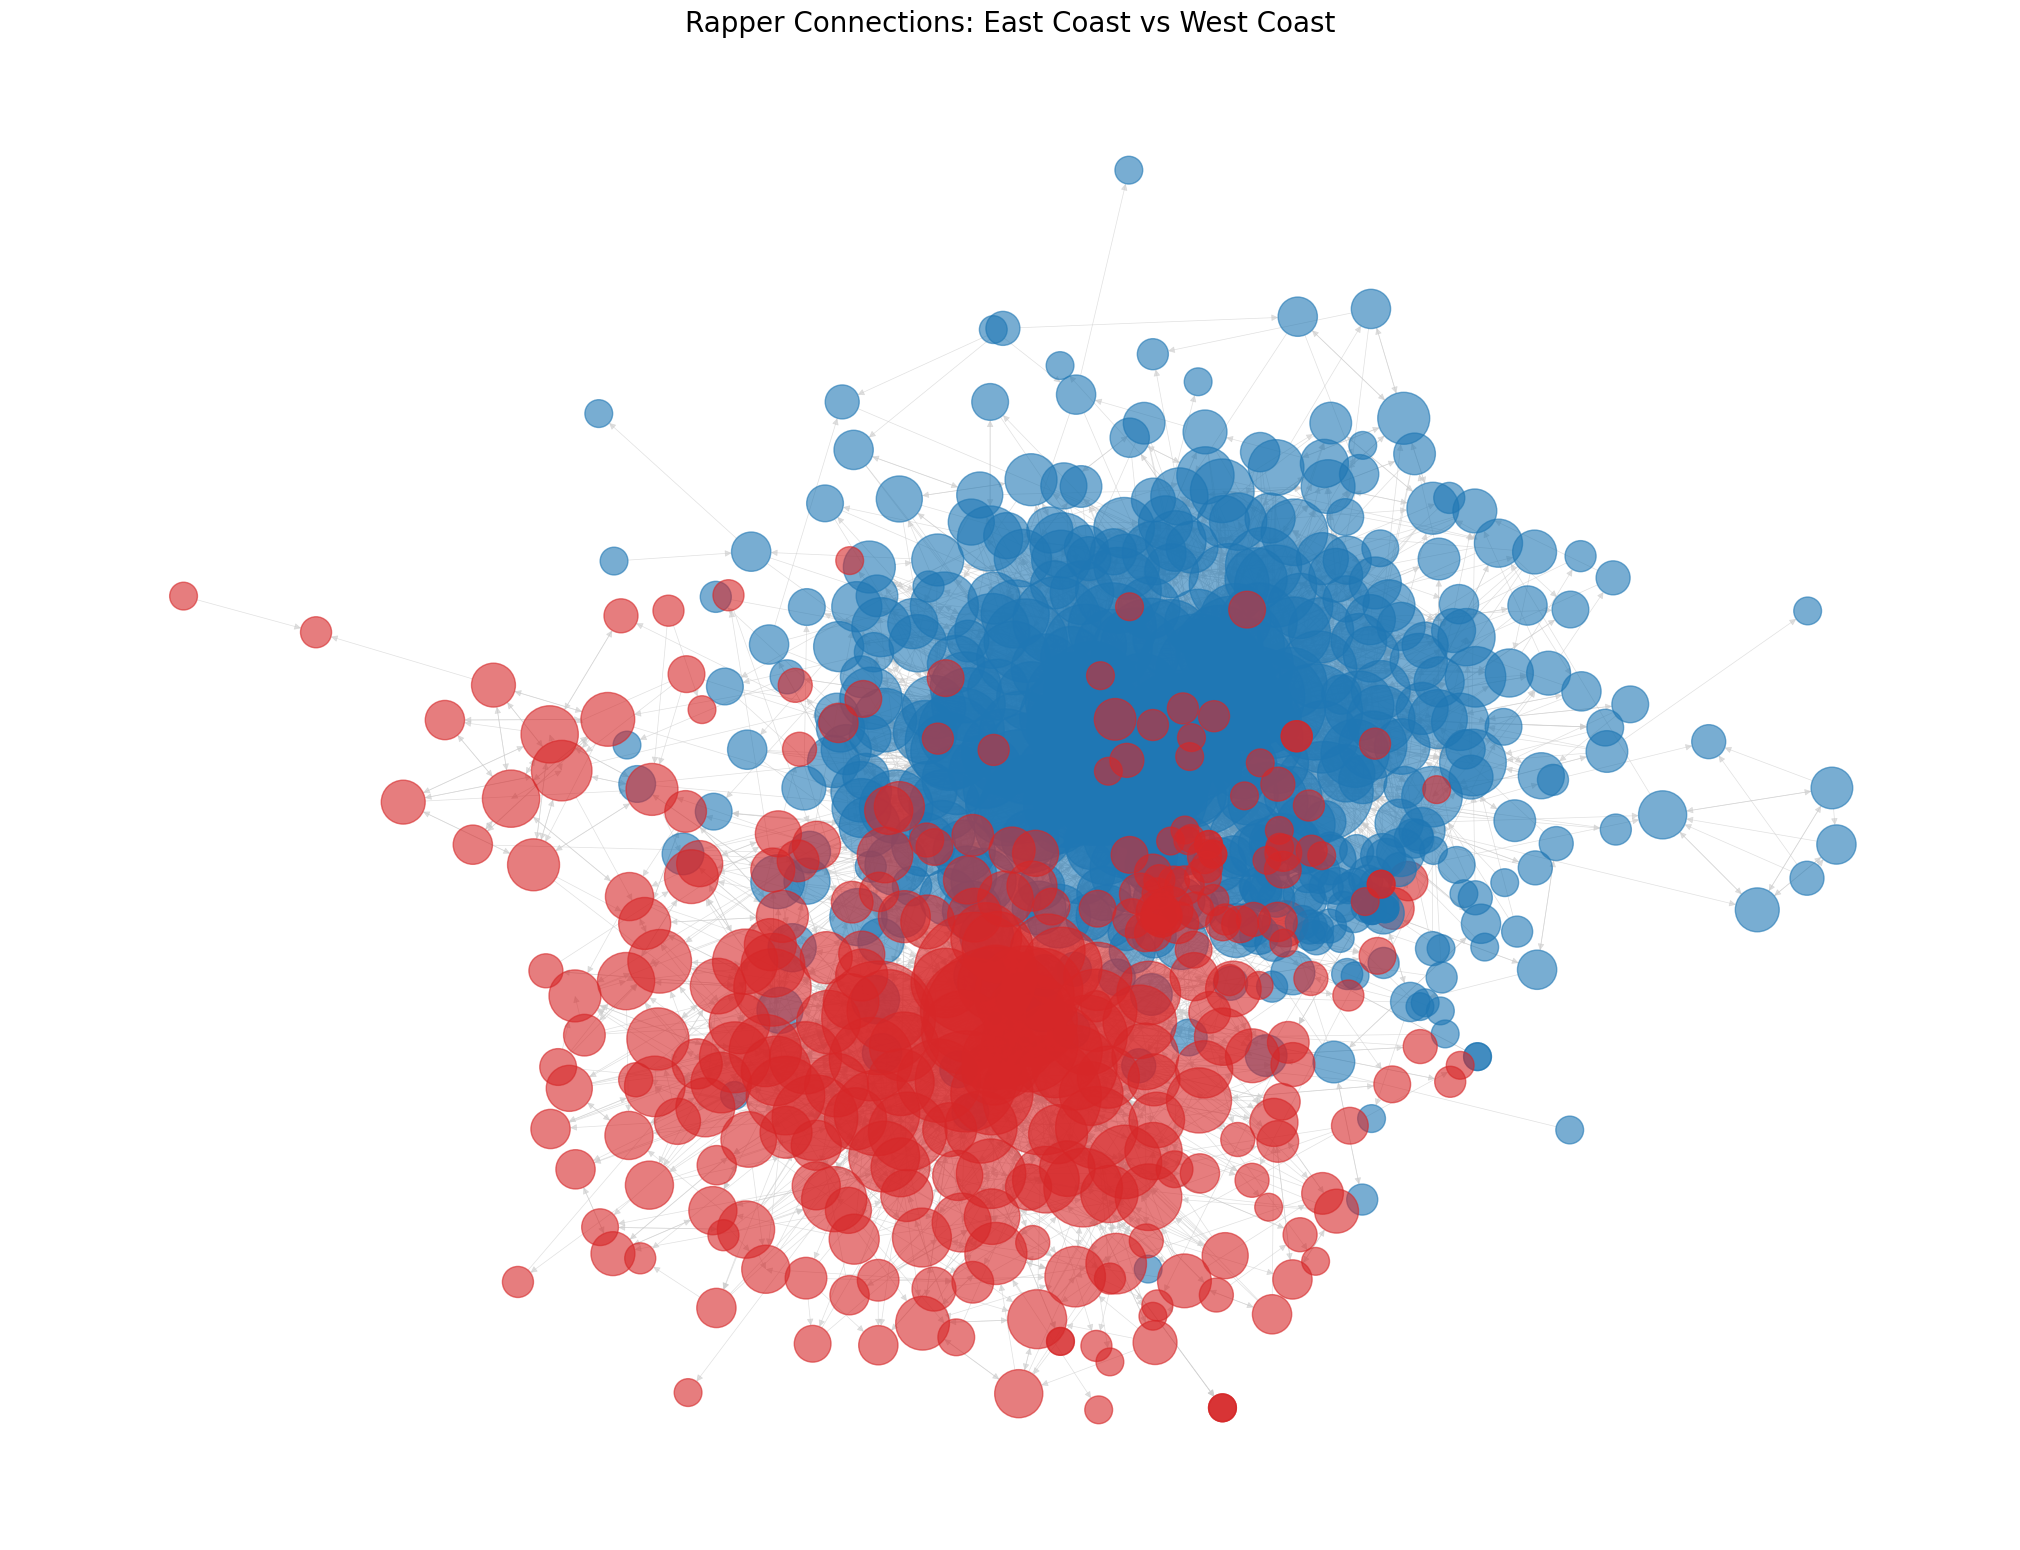

In [14]:
import os
import networkx as nx
import matplotlib.pyplot as plt

# Load content from saved files
def load_content_from_files(folder_name):
    rapper_connections = {}
    for filename in os.listdir(folder_name):
        rapper_name = filename[:-4]  # Remove .txt extension
        with open(f"{folder_name}/{filename}", "r", encoding="utf-8") as file:
            content = file.readlines()
        rapper_connections[rapper_name] = {'Page Content': ''.join(content)}
    return rapper_connections

east_coast_rapper_content = load_content_from_files("eastcoast")
west_coast_rapper_content = load_content_from_files("westcoast")

G = nx.DiGraph()

def add_rappers_to_graph(rapper_content, color):
    for rapper_name, content in rapper_content.items():
        G.add_node(rapper_name, color=color)
        
        for other_rapper_name in rapper_content.keys():
            if other_rapper_name.lower() in content['Page Content'].lower() and rapper_name != other_rapper_name:
                G.add_edge(rapper_name, other_rapper_name)

add_rappers_to_graph(east_coast_rapper_content, '#1f77b4')  # Adjusted blue color
add_rappers_to_graph(west_coast_rapper_content, '#d62728')  # Adjusted red color

isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

# Visualization
plt.figure(figsize=(20, 15))

# Using kamada_kawai_layout for better spacing and positioning
pos = nx.kamada_kawai_layout(G)

node_sizes = [G.degree(node) * 100 + 300 for node in G.nodes()]  # Scale node size by degree

node_colors = [data['color'] for node, data in G.nodes(data=True)]

nx.draw(G, pos, 
        node_size=node_sizes, 
        node_color=node_colors, 
        edge_color='#CCCCCC', 
        width=0.5, 
        alpha=0.6,
        with_labels=False)

plt.axis('off')
plt.title("Rapper Connections: East Coast vs West Coast", fontsize=20)
plt.show()



- **Describe the structure you observe. What useful information can you decipher from this?**

- We can observe that the nodes are color-coded, we chose blue for representing East Coast rappers and red representing West Coast rappers.
- The presence of a distinct, dense cluster of blue nodes in the middle of the graph indicates a strong interconnectivity among the East Coast rappers.
- Similarly, a dense cluster of red nodes shows that West Coast rappers also have strong connections among themselves.

- We can observe that lines (edges) that connect blue nodes to red nodes and vice versa. These represent connections or mentions between rappers from the different coasts.

- The fact that these connections exist but aren't overwhelmingly dense suggests that while there is some interaction between East Coast and West Coast rappers, a lot of their interactions are within their respective coasts.

- We can observe that nodes that are farther away from the central cluster tend to have fewer connections. This can suggest that these rappers might not be as central or influential in the network, or they may represent newer artists who haven't formed as many connections yet.

- we can observe that the central region of the graph is very dense, indicating that many rappers have multiple connections with each other. This can suggest that there's a core group of rappers within each coast that are frequently mentioned or collaborated with, making them central figures in the network.

- Our graph visualizes the connections between East Coast and West Coast rappers. It showcases that while there are interactions between the two coasts, a lot of the interactions and mentions are within their respective coasts. There's a core group within each coast that is highly interconnected, and then there are peripheral rappers with fewer connections.